讓我們來用主成分分析來對葡萄酒數據集進行分析。或許我們會發現，只需要用到13個特徵中的很少部分，就能分開這些資料。

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_wine = pd.read_csv('wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
df_wine.head()

# 生成訓練集與測試集
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# 標準化
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

來手刻製作一個PCA演算法
PCA的原理：PCA是一種非顛督學習，藉由觀察特徵之間的相關性以識別出模式。我們希望找到一個線性變換，使得原本的數據集經由變換後，可轉換到較低維度的特徵空間。且此時這個維度較低之特徵空間的基底，稱為「正交軸」。此時數據集應使用標準化的數據集，因為變異數十分敏感。
作法：
1. 引進$d$維數據集$X$
2. 建立共變異數矩陣$\Sigma$
3. 計算$\Sigma$的特徵值$\lambda_i$與特徵向量$v_i$
4. 根據$\lambda_i$對$v_i$由大而小排序
5. 選取前$k$個特徵向量$\{v_1,...,v_k\}$作為主成分，$k\leq d$
6. 特徵矩陣$W=[v_1\quad v_2\quad...\quad v_k]$
7. 降維後的數據集$X_k=W(X)$

In [2]:
import numpy as np

cov_mat = np.cov(X_train_std.T) # 計算特徵值
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)

# Make a list of (eigenvalue, eigenvector) tuples, eigenvalue越大者越重要
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
# 我們假設只取兩個特徵(下兩個block會解釋)
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis])) #只取最重要的兩個特徵
print('Matrix W:\n', w)

# 將數據集映射，完成降維
X_train_std[0].dot(w) # 只有兩個特徵


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]
Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


array([2.38299011, 0.45458499])

對於每個特徵，其重要性可以用$\textbf{解釋變異數比率}$表示。其定義為某特徵之特徵值除以特徵值總和$$\frac{\lambda_i}{\sum_{j=1}^d\lambda_j}$$

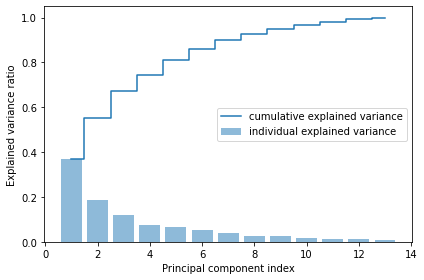

In [3]:
import matplotlib.pyplot as plt

# 把explained variance(lambda i / lambda和)由大排到小
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp) # 計算解釋變異數

# 繪圖
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()

我們大膽的假設：或許只要取前兩個特徵即可。為驗證此假設，我們將繪製原始數據集的前兩個特徵的散佈圖。

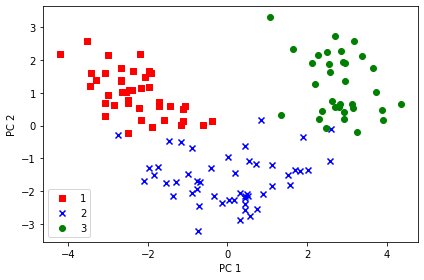

In [4]:
X_train_pca = X_train_std.dot(w) # 將標準化後的數據集利用W矩陣降維

#繪圖區
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_03.png', dpi=300)
plt.show()

用邏輯斯回歸做實驗。直觀上原始數據的正確率應該會較高，但只要使用PCA之後正確率仍差不多，就代表選擇如此多的特徵足矣。

In [5]:
from sklearn.linear_model import LogisticRegression

# 使用PCA
X_test_pca = X_test_std.dot(w)
lr_PCA = LogisticRegression(penalty='l2', C=0.08, random_state=1, solver='lbfgs', multi_class='ovr')
lr_PCA.fit(X_train_pca, y_train)
y_pred = lr_PCA.predict(X_test_pca)
print('Misclassified instances of logistic regression with PCA %d' % (y_test != y_pred).sum())
print('Accuracy %.2f' % lr_PCA.score(X_test_pca, y_test))

# 原始數據
lr = LogisticRegression(penalty='l2', C=0.08, random_state=1, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)
print('Misclassified instances of logistic regression without PCA %d' % (y_test != y_pred).sum())
print('Accuracy %.2f' % lr.score(X_test_std, y_test))

Misclassified instances of logistic regression with PCA 4
Accuracy 0.93
Misclassified instances of logistic regression without PCA 0
Accuracy 1.00


Scikit learn裡面也有PCA演算法可以直接調用，在那之前，先呼叫一個老朋友：決策邊界繪製

In [6]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

用scikit learn的PCA演算法轉換數據集後，畫看看訓練集與測試集的散佈圖與決策邊界。散佈圖畫出來可能跟我們手刻的PCA有一點不同。這是因為scikit learn的特徵向量計算方法有點不一樣，導致特徵向量有正有負，但這其實不大影響分類器性能

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


訓練集:


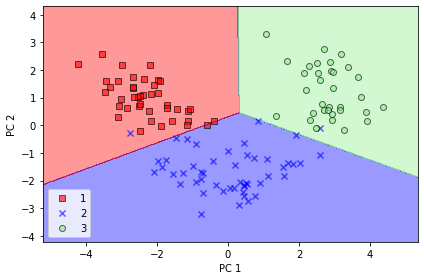

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


測試集:


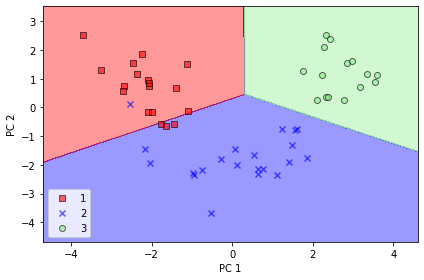

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# 可以直接利用PCA轉換數據集喔
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(penalty='l2',  C=0.08, random_state=1, solver='lbfgs', multi_class='ovr')
lr = lr.fit(X_train_pca, y_train) # training...

# 繪圖區
print('訓練集:')
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

print('測試集:')
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_05.png', dpi=300)
plt.show()